In [1]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

from tensorflow.keras.models import load_model



2024-10-09 14:35:18.448566: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-10-09 14:35:18.598841: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-10-09 14:35:18.598863: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-10-09 14:35:18.599877: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-10-09 14:35:18.674608: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-10-09 14:35:18.675413: I tensorflow/core/platform/cpu_feature_guard.cc:182] This Tens

In [2]:

### Check running with tensorflow-GPU
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'  # or any {'0', '1', '2'}


version = tf.__version__
gpu_ok = tf.test.is_gpu_available()


print('Tensorflow',version,'is running with GPU. [', gpu_ok, ']')
print('\n')



Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.
Tensorflow 2.14.0 is running with GPU. [ False ]




2024-10-09 14:35:21.981044: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-10-09 14:35:21.981585: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2211] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


In [3]:

#data_Train_input_param = pd.read_csv('./new_Data_20231023/train_para_2000.csv').values
#data_Train_outputs = pd.read_csv('./new_Data_20231023/train_2000_nn_data_new.csv').values
data_Train_input_param = pd.read_csv('./train_para_2000.csv').values
data_Train_outputs = pd.read_csv('./train_2000_nn_data_new_1330.csv').values

## Slip data
X, y = data_Train_input_param[:, 1:], data_Train_outputs[:, 1:]

X = np.transpose(X)
y = np.transpose(y)

print(X.shape)
print(y.shape)



FileNotFoundError: [Errno 2] No such file or directory: './train_2000_nn_data_new_1330.csv'

In [6]:

#### Normalise the data
X[:,3] = X[:,3] /10000
X[:,4] = X[:,4] /1000
y = y / 1000


X = np.expand_dims(X, axis=-1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)



In [7]:

print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)



(1600, 5, 1)
(1600, 49)
(400, 5, 1)
(400, 49)


In [6]:
# print(X_train[0,:])
# print(y_train[0,:])

In [8]:

import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.models import Model


def ICP_model(F_num,ch_num):
    Input = layers.Input(shape=(F_num,ch_num))
    
    ### ResNet Block #1
    X = layers.Conv1D(48, 3, activation='relu', padding='same')(Input)
    print(X.shape)
    X0 = X
    X = layers.Conv1D(48, 3, activation='relu', padding='same')(X)
    print(X.shape)
    X = layers.Conv1D(48, 3, activation= None, padding='same')(X)
    print(X.shape)
    X = layers.Add()([X, X0])
    X = layers.Activation('relu') (X)
#     X = layers.BatchNormalization(axis = -1)(X)
    
    
    
    ### ResNet Block #2
    X = layers.Conv1D(64, 3, activation='relu', padding='same')(X)
    X1 = X
    X = layers.Conv1D(64, 3, activation='relu', padding='same')(X)
    X = layers.Conv1D(64, 3, activation= None, padding='same')(X)
    X = layers.Add()([X, X1])
    X = layers.Activation('relu') (X)
#     X = layers.BatchNormalization(axis = -1)(X)
    
    
    X = layers.Flatten()(X)
    Output = layers.Dense(49)(X)
    
    model = Model(inputs = Input, outputs = Output)

    return model


### Get the model
F_num = 5
ch_num = 1
model = ICP_model(F_num,ch_num)


model_str = 'Conv_64_ResNet'

model_name = model_str + '.hdf5'
print(model_name)



(None, 5, 48)
(None, 5, 48)
(None, 5, 48)
Conv_64_ResNet.hdf5


2023-11-28 20:32:18.331733: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-11-28 20:32:18.331875: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2211] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


In [11]:

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')
history = model.fit(X_train, y_train, 
          epochs=100, 
          validation_split=0.1,
          batch_size=16, 
          verbose=0,
          shuffle=True)



In [10]:

# Evaluate the model on the testing set
y_test_pred = model.predict(X_test)
y_test = y_test.squeeze()
y_test_pred = y_test_pred.squeeze()

mse = mean_squared_error(y_test, y_test_pred)
print(f"Testing Mean Squared Error: {mse}")



13/13 [==============================] - 0s 2ms/step
Testing Mean Squared Error: 0.0007820947982153144


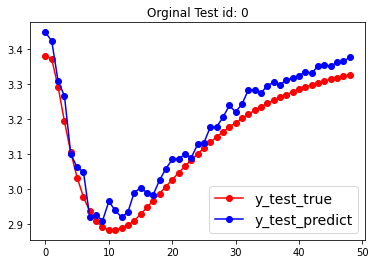

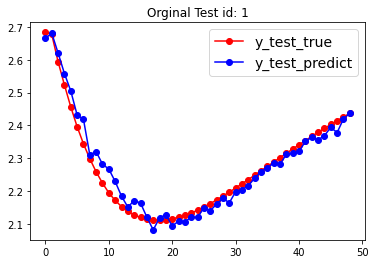

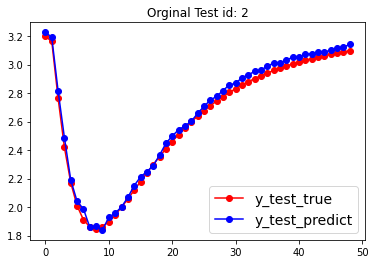

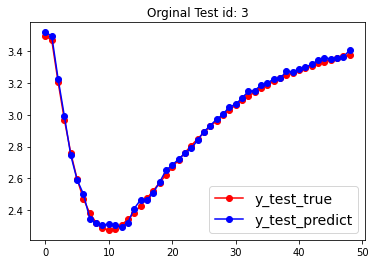

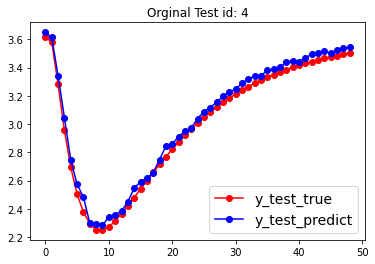

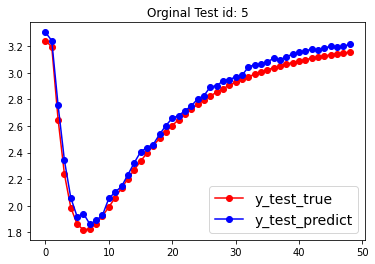

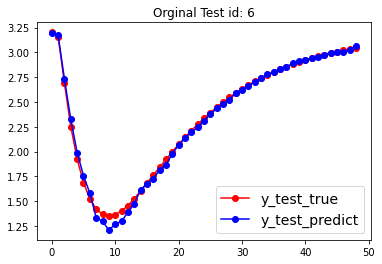

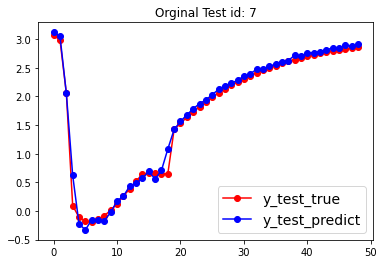

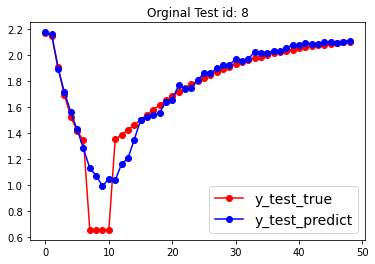

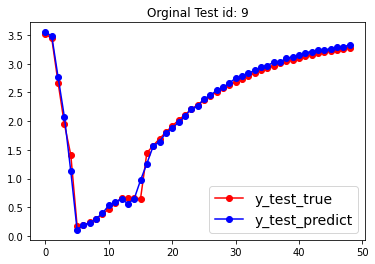

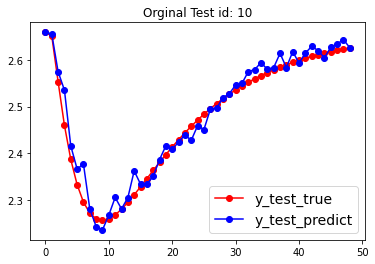

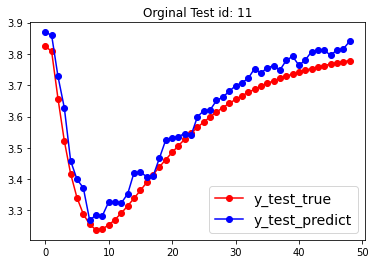

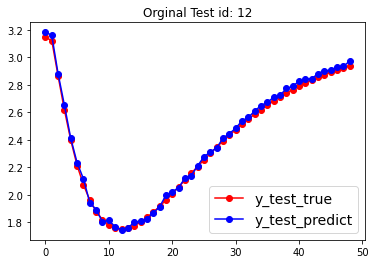

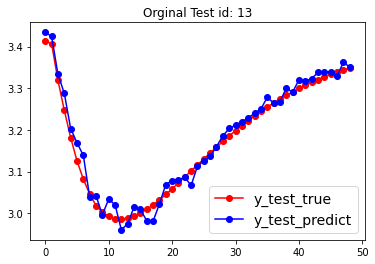

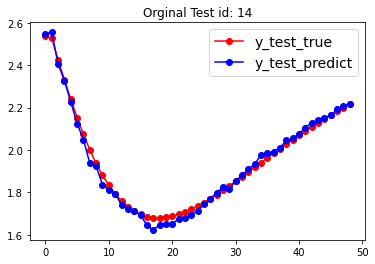

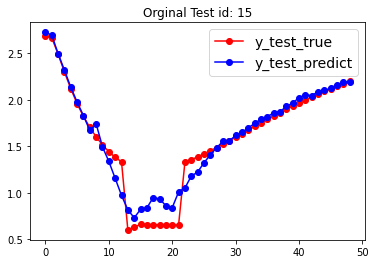

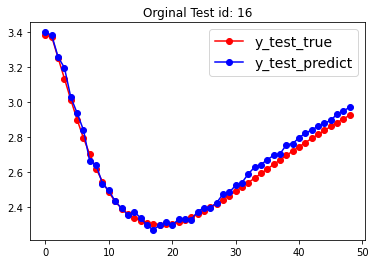

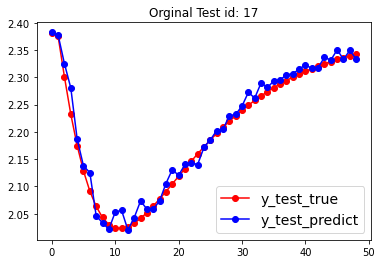

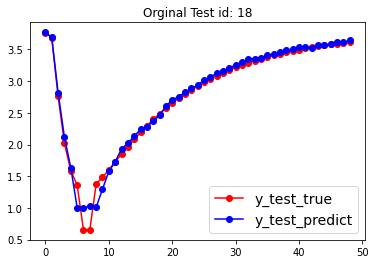

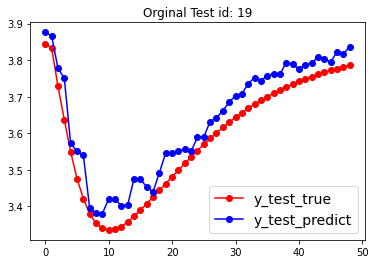

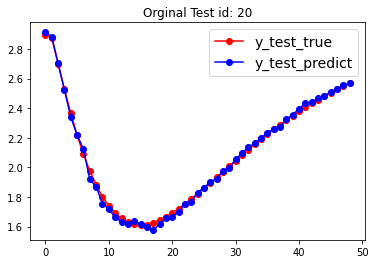

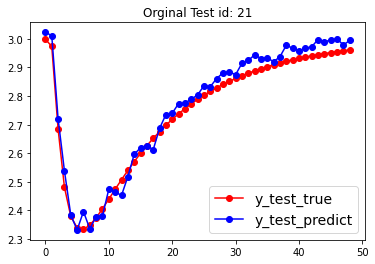

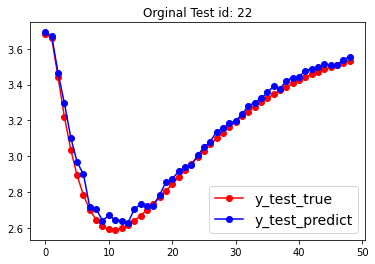

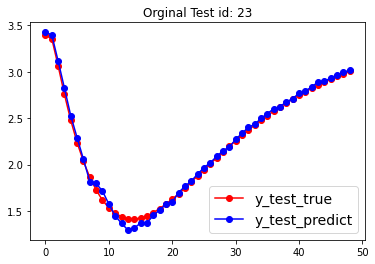

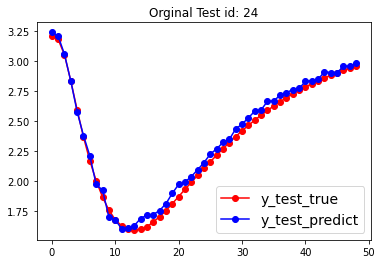

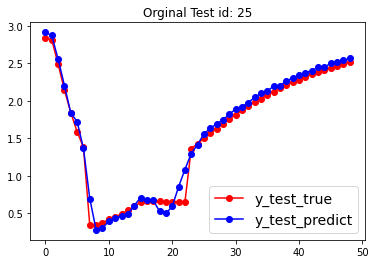

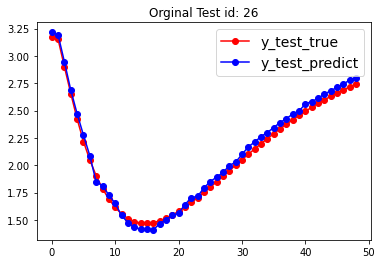

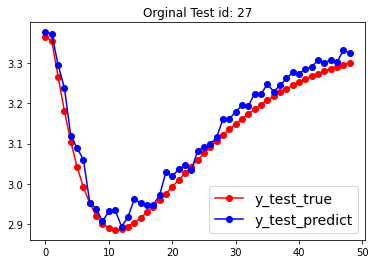

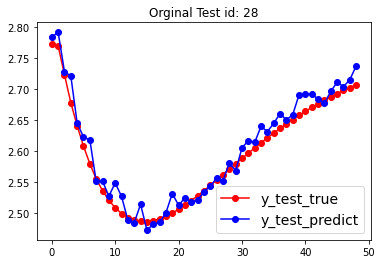

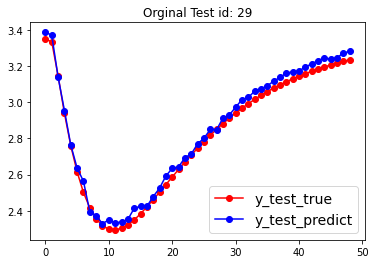

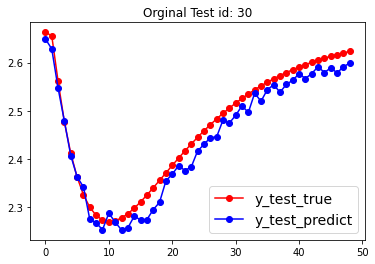

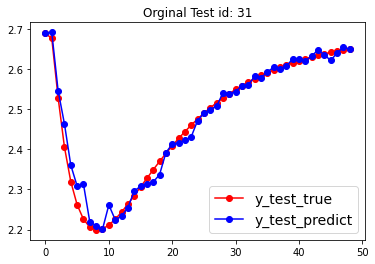

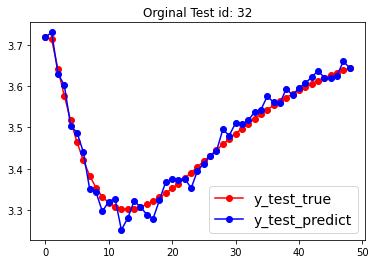

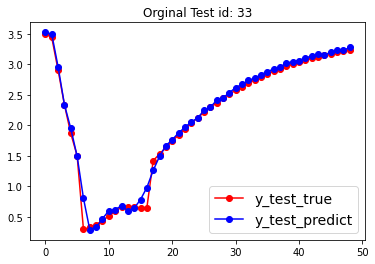

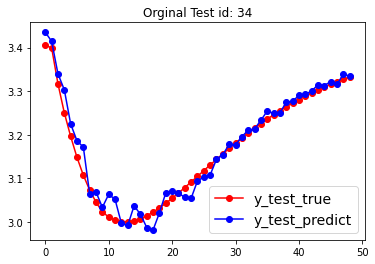

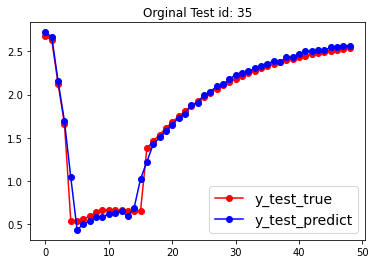

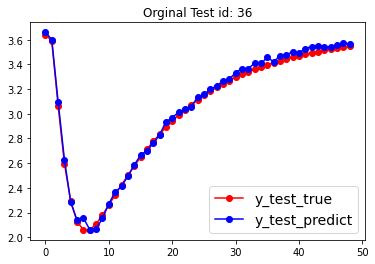

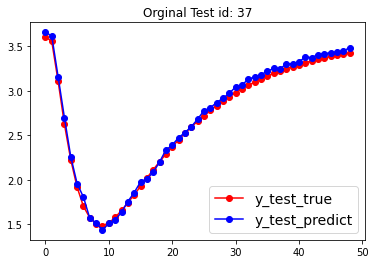

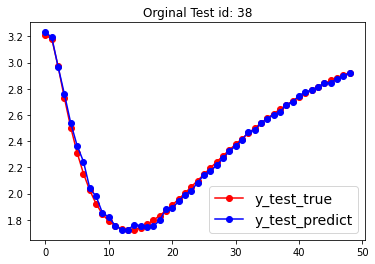

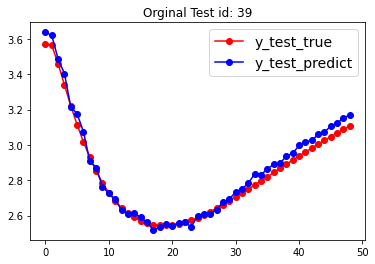

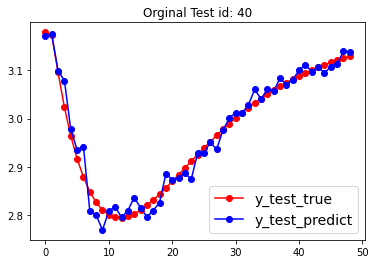

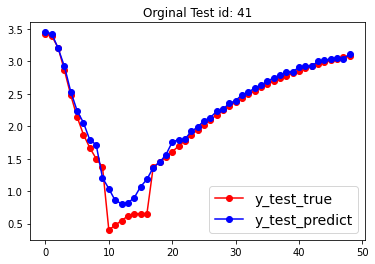

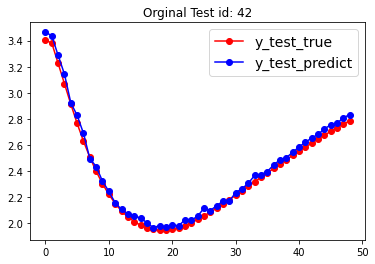

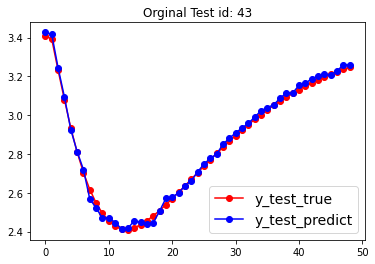

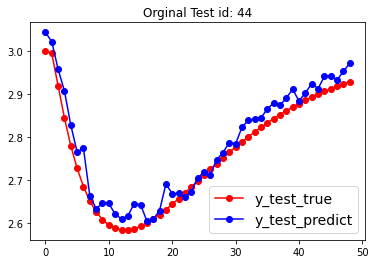

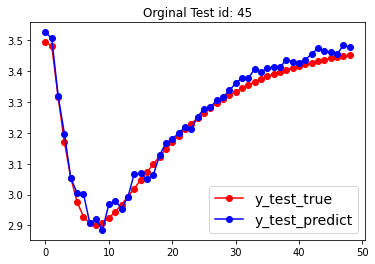

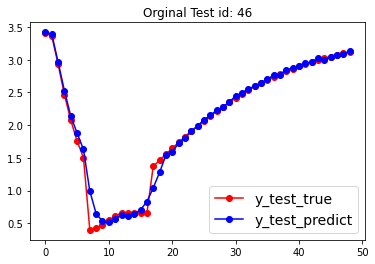

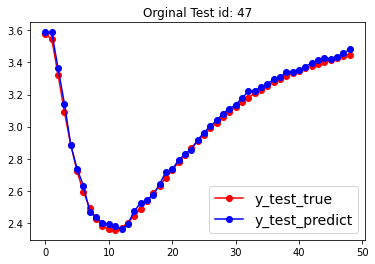

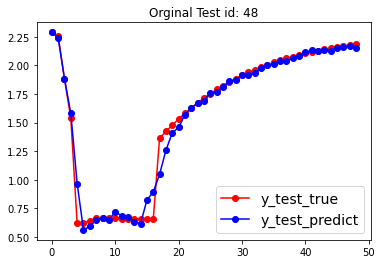

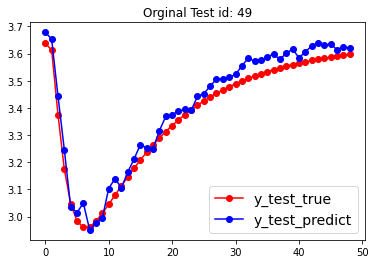

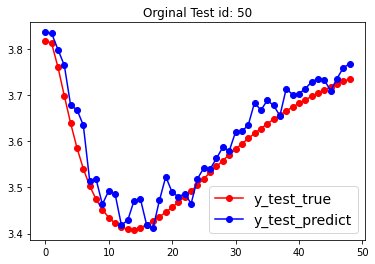

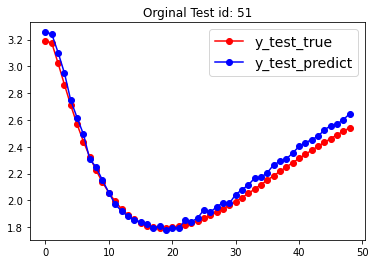

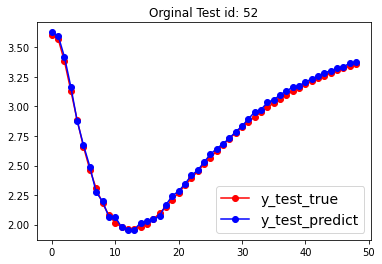

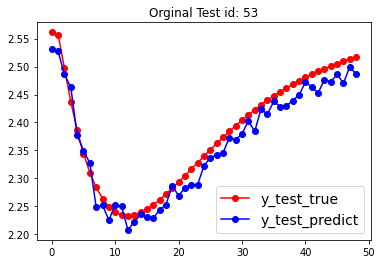

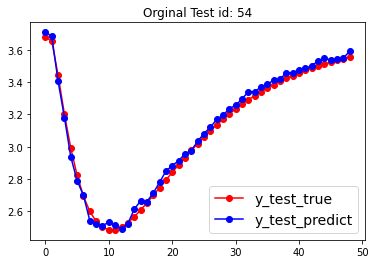

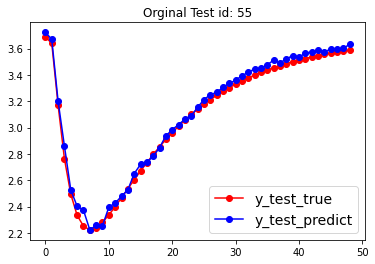

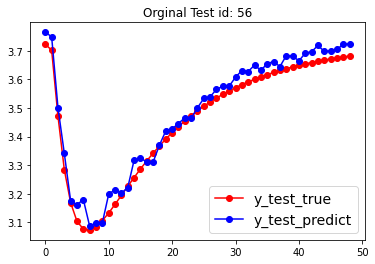

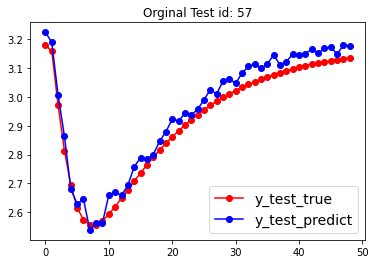

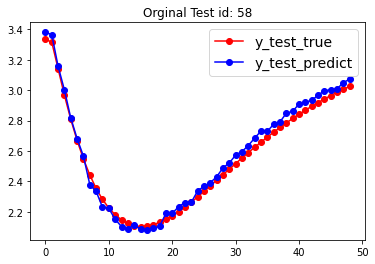

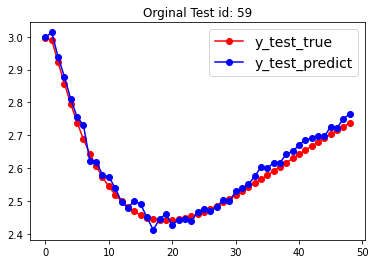

In [10]:

### Plot the result
for idd in range(60):
    y_t = y_test
    y_p = y_test_pred
    plt.plot(y_t[idd,:], '-o', color = 'red', label = 'y_test_true')
    plt.plot(y_p[idd,:], '-o', color = 'blue', label = 'y_test_predict')
    plt.title('Orginal Test id: ' + str(idd))

    plt.legend(fontsize=14)
    plt.show()

